# Example RNN Training
- (already processed) data prep
    - run preprpcessing notebook first
- RNN definition
- Training session
- Evaluate with visualization

In [1]:
%load_ext autoreload
%autoreload 2
p = print

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

import os
import pickle

from crypr.util import get_project_path

coin = 'BTC'
data_path = os.path.join(get_project_path(), 'data', 'processed')

In [4]:
"""
Import Data.
"""
Ty = 1
Tx = 72
feature_lag = 72

X_train = pd.read_csv(os.path.join(data_path, 'X_train_{}_tx{}_ty{}_flag{}.csv'.format(coin, Tx, Ty, feature_lag)))
Y_train = pd.read_csv(os.path.join(data_path, 'Y_train_{}_tx{}_ty{}_flag{}.csv'.format(coin, Tx, Ty, feature_lag)))
X_test = pd.read_csv(os.path.join(data_path, 'X_test_{}_tx{}_ty{}_flag{}.csv'.format(coin, Tx, Ty, feature_lag)))
Y_test = pd.read_csv(os.path.join(data_path, 'Y_test_{}_tx{}_ty{}_flag{}.csv'.format(coin, Tx, Ty, feature_lag)))

N_FEATURES = int(X_train.columns.values.size / Tx)

In [5]:
"""
Evaluate Dummy Models.
"""

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

for strategy in ['mean', 'median', 'constant']:
    
    if strategy=='constant':
        dummy=DummyRegressor(strategy=strategy, constant=(0,))
    else:
        dummy=DummyRegressor(strategy=strategy)
        
    p('\nTraining dummy model on training data with strategy {} ...'.format(strategy))
    dummy.fit(X_train, Y_train)
    
    p('\nPerformance on train data:')
    dummy_predict_train = dummy.predict(X_train)
    print('{} MAE: {}'.format(strategy, mean_absolute_error(y_true=Y_train, y_pred=dummy_predict_train)))
    print('{} MSE: {}'.format(strategy, mean_squared_error(y_true=Y_train, y_pred=dummy_predict_train)))
    
    p('\nPerformance on test data:')
    dummy_predict_test = dummy.predict(X_test)
    print('{} MAE: {}'.format(strategy, mean_absolute_error(y_true=Y_test, y_pred=dummy_predict_test)))
    print('{} MSE: {}'.format(strategy, mean_squared_error(y_true=Y_test, y_pred=dummy_predict_test)))


Training dummy model on training data with strategy mean ...

Performance on train data:
mean MAE: 0.3695222020046031
mean MSE: 0.48625747331323094

Performance on test data:
mean MAE: 0.2217517553481902
mean MSE: 0.21963581921279998

Training dummy model on training data with strategy median ...

Performance on train data:
median MAE: 0.36936108418422636
median MSE: 0.4863652734960349

Performance on test data:
median MAE: 0.22107701575044109
median MSE: 0.2199904474151505

Training dummy model on training data with strategy constant ...

Performance on train data:
constant MAE: 0.36938401321540526
constant MSE: 0.48629137666678995

Performance on test data:
constant MAE: 0.22127302180879313
constant MSE: 0.21980814485940342


In [7]:
"""
Reshape the model into a 3D array to fit the RNN Model.
"""
def shape_model_data(X, n_timesteps, n_features):
    return X.reshape((X.shape[0], n_timesteps, n_features))

In [8]:
"""
Define preprocessing steps.
"""
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('reshape', FunctionTransformer(shape_model_data, kw_args=dict(n_timesteps=Tx, n_features=N_FEATURES)))
])

In [10]:
"""
Transform the feature data.
"""
model_X_train = pipeline.fit_transform(X_train)
model_X_test = pipeline.fit_transform(X_test)

/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.

In [11]:
from keras.layers import Input, LSTM, BatchNormalization, Dense
from keras import Model

from keras.initializers import RandomNormal, Ones, Constant

def lstm_model(input_shape, num_outputs, kernel_init='normal', bias_init='zeros'): 
    model_input = Input(shape=input_shape, dtype='float32')

    X = LSTM(units=64, return_sequences=True, kernel_initializer=kernel_init, bias_initializer=bias_init)(model_input)
    X = BatchNormalization(axis=-1)(X)
    
    X = LSTM(units=64, return_sequences=False, kernel_initializer=kernel_init, bias_initializer=bias_init)(X)
    X = BatchNormalization(axis=-1)(X)
    
    X = Dense(num_outputs, kernel_initializer=kernel_init, bias_initializer=bias_init, activation='linear')(X)

    return Model(inputs=model_input, outputs=X)

Using TensorFlow backend.


In [13]:
model = lstm_model(model_X_train.shape[1:], Ty)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72, 17)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 72, 64)            20992     
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 64)            256       
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 54,593
Trainable params: 54,337
Non-trainable params: 25

In [14]:
from keras.optimizers import Adam
"""
Set model training parameters.
"""
epochs = 5
batch_size = 32
learning_rate=.001
decay_rate = learning_rate / epochs

"""
Compile and fit model.
"""
model.compile(loss='mse', optimizer=Adam(lr=learning_rate, decay=decay_rate), metrics=['mae'])

fit = model.fit(model_X_train, Y_train,
                shuffle=False,
                epochs=epochs, 
                batch_size=batch_size, 
                validation_data=(model_X_test, Y_test)
               )

Instructions for updating:
Use tf.cast instead.
Train on 5563 samples, validate on 293 samples
Epoch 1/5
5563/5563 [==============================] - 27s 5ms/step - loss: 0.5067 - mean_absolute_error: 0.4106 - val_loss: 0.8268 - val_mean_absolute_error: 0.6900
Epoch 2/5
5563/5563 [==============================] - 25s 4ms/step - loss: 0.4727 - mean_absolute_error: 0.3815 - val_loss: 1.3507 - val_mean_absolute_error: 0.9497
Epoch 3/5
5563/5563 [==============================] - 24s 4ms/step - loss: 0.4570 - mean_absolute_error: 0.3760 - val_loss: 1.9088 - val_mean_absolute_error: 1.1484
Epoch 4/5
5563/5563 [==============================] - 24s 4ms/step - loss: 0.4481 - mean_absolute_error: 0.3719 - val_loss: 2.1951 - val_mean_absolute_error: 1.2842
Epoch 5/5
5563/5563 [==============================] - 23s 4ms/step - loss: 0.4439 - mean_absolute_error: 0.3738 - val_loss: 1.3777 - val_mean_absolute_error: 1.0246


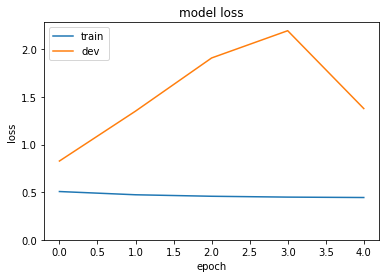

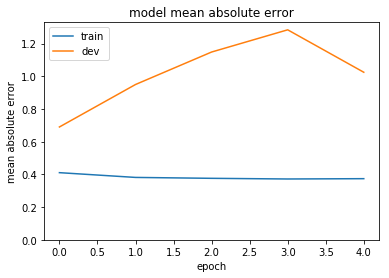

In [15]:
"""
Check out loss from train and dev sets
"""
plt.plot(fit.history['loss'], label='train')
plt.plot(fit.history['val_loss'], label='dev')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,None])
plt.legend()
plt.show()

"""
Check out mean absolute error from train and dev sets
"""
plt.plot(fit.history['mean_absolute_error'], label='train')
plt.plot(fit.history['val_mean_absolute_error'], label='dev')
plt.title('model mean absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.ylim([0,None])
plt.legend()
plt.show()

In [16]:
backtest=model.predict(model_X_train)
prediction = model.predict(model_X_test)

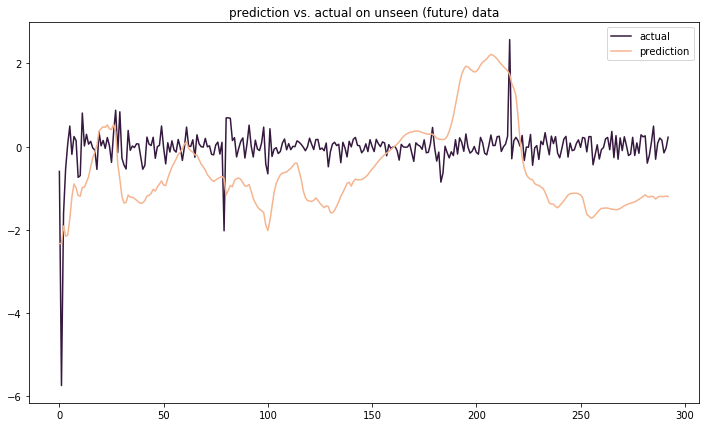

In [17]:
fig,ax=plt.subplots(figsize=(12,7))
plt.plot(Y_test.values, c=sns.color_palette('rocket')[0], label='actual')
plt.plot(prediction, c=sns.color_palette('rocket')[5], label='prediction')
plt.title('prediction vs. actual on unseen (future) data')
plt.legend()

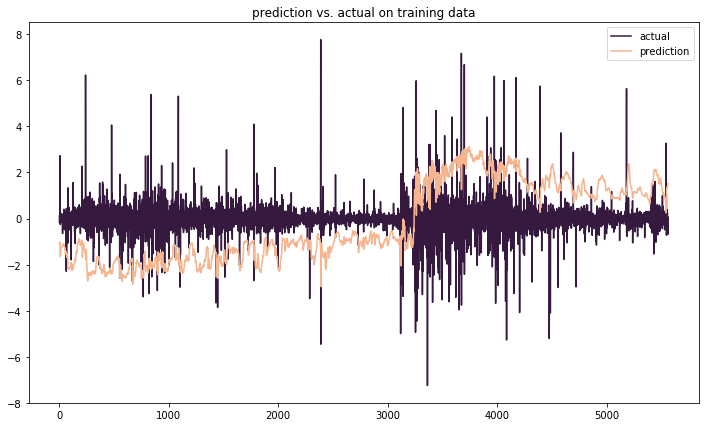

In [18]:
fig,ax=plt.subplots(figsize=(12,7))
plt.plot(Y_train.values, c=sns.color_palette('rocket')[0], label='actual')
plt.plot(backtest, c=sns.color_palette('rocket')[5], label='prediction')
plt.title('prediction vs. actual on training data')
plt.legend()